In [10]:
import sqlite3
import matplotlib.pyplot as plt
from math import ceil, sqrt

from glitch_utils import GlitchResult
conn = sqlite3.connect('file:glitch2.db?mode=ro', uri=True)
c = conn.cursor()

simplify_color = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'sy', # Yellow
	GlitchResult.NORMAL					: 'sg', # Green
	GlitchResult.WEIRD					: 'sy', # Yellow
	GlitchResult.SUCCESS				: 'sr', # Red
	GlitchResult.HALF_SUCCESS			: 'sy', # Yellow
	GlitchResult.BROKEN					: 'sy', # Yellow
}

simplify_color_half = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'sy', # Yellow
	GlitchResult.NORMAL					: 'sg', # Green
	GlitchResult.WEIRD					: 'sy', # Yellow
	GlitchResult.SUCCESS				: 'sr', # Red
	GlitchResult.HALF_SUCCESS			: 'sr', # Red
	GlitchResult.BROKEN					: 'sy', # Yellow
}
mapper = simplify_color_half

def summarize(results):
	tot = len(results)
	replaced = [mapper[result] for result in results]
	yellow = replaced.count('sy')
	green = replaced.count('sg')
	red = replaced.count('sr')
	print('Results:')
	print(f'  Total = {tot}')
	print(f'  Yellow = {yellow} - {yellow/tot*100:.2f}%')
	print(f'  Green = {green} - {green/tot*100:.2f}%')
	print(f'  Red = {red} - {red/tot*100:.2f}%')

def get_settings(table_name: str) -> str:
	c.execute('SELECT settings FROM settings WHERE table_name = ?', (table_name,))
	return c.fetchone()[0]

Results:
  Total = 62867
  Yellow = 5542 - 8.82%
  Green = 57324 - 91.18%
  Red = 1 - 0.00%


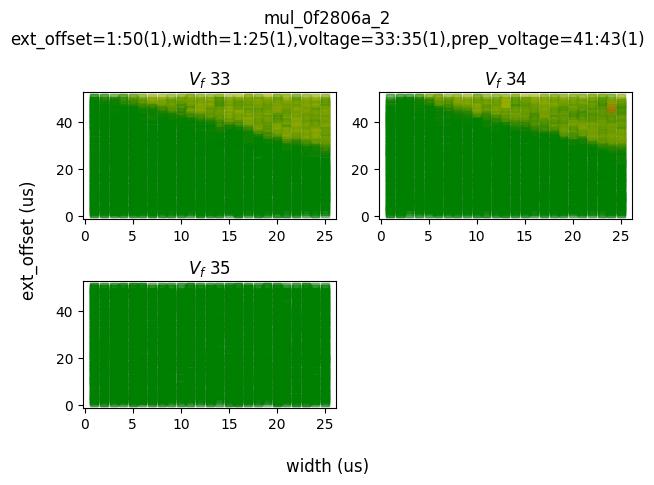

In [30]:
TABLE = 'mul_0f2806a_2'
settings = get_settings(TABLE).split(',')

c.execute(f'SELECT DISTINCT voltage FROM {TABLE}')
voltages = [v for (v,) in c.fetchall()]
voltages.sort()

col_num = ceil(sqrt(len(voltages)))
row_num = ceil(len(voltages) / col_num)

fig = plt.figure(layout="tight")
fig.suptitle(f'{TABLE}\n{','.join(settings)}')
axs = {}
for i, voltage in enumerate(voltages):
	axs[voltage] = fig.add_subplot(row_num, col_num, i+1)
	axs[voltage].set_title(f'$V_f$ {voltage}')
	fig.supxlabel('width (us)')
	fig.supylabel("ext_offset (us)")

c.execute(f'SELECT * FROM {TABLE}')
rows = c.fetchall()

summarize([GlitchResult[result_name] for (_, _, _, _, result_name, _, _, _, _) in rows])

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# # if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	# if result == GlitchResult.NORMAL:
	# 	continue
	marker = mapper[result]
	alpha = 0.05 if marker != 'sr' else 0.5
	axs[voltage].plot(width, ext_offset, marker, alpha=alpha)

## One plot per Vp

Prep voltage 41
Results:
  Total = 20986
  Yellow = 1894 - 9.03%
  Green = 19092 - 90.97%
  Red = 0 - 0.00%
Prep voltage 42
Results:
  Total = 20966
  Yellow = 1855 - 8.85%
  Green = 19111 - 91.15%
  Red = 0 - 0.00%
Prep voltage 43
Results:
  Total = 20915
  Yellow = 1793 - 8.57%
  Green = 19121 - 91.42%
  Red = 1 - 0.00%


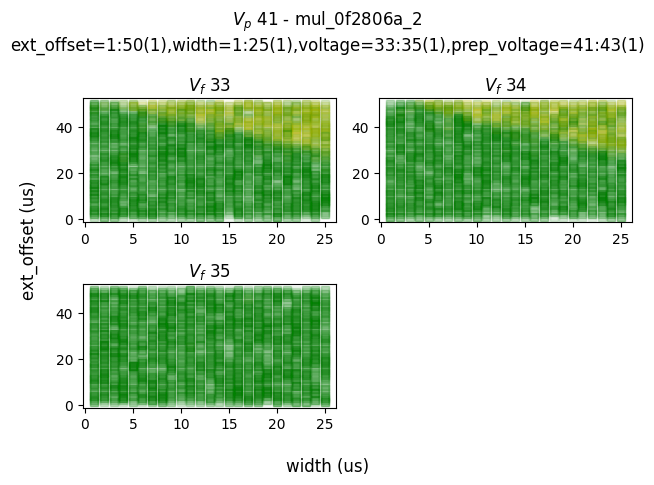

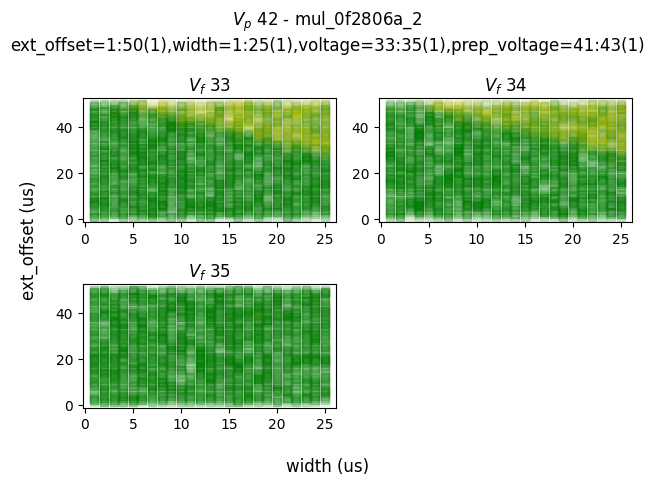

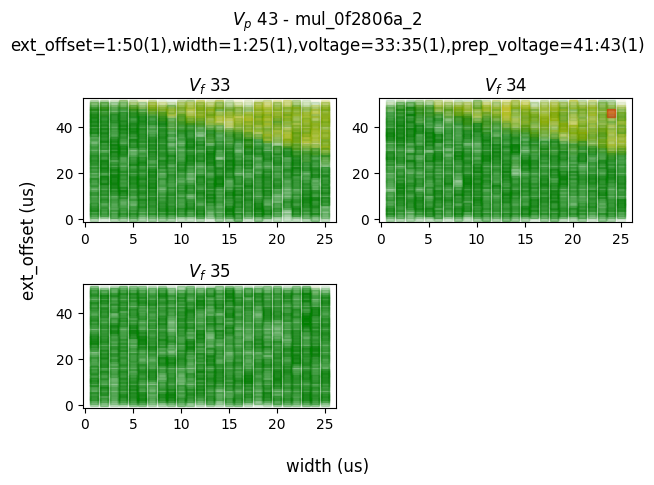

In [32]:
TABLE = 'mul_0f2806a_2'
settings = get_settings(TABLE).split(',')

c.execute(f'SELECT DISTINCT voltage FROM {TABLE}')
voltages = [v for (v,) in c.fetchall()]
voltages.sort()
col_num = ceil(sqrt(len(voltages)))
row_num = ceil(len(voltages) / col_num)

c.execute(f'SELECT DISTINCT prep_voltage FROM {TABLE}')
prep_voltages = [v for (v,) in c.fetchall()]
prep_voltages.sort()

figs = {}
for v_p in prep_voltages:
	figs[v_p] = plt.figure(layout="tight")
	figs[v_p].suptitle(f'$V_p$ {v_p} - {TABLE}\n{','.join(settings)}')
	axs = {}
	for i, voltage in enumerate(voltages):
		axs[voltage] = figs[v_p].add_subplot(row_num, col_num, i+1)
		axs[voltage].set_title(f'$V_f$ {voltage}')
		figs[v_p].supxlabel('width (us)')
		figs[v_p].supylabel("ext_offset (us)")

	c.execute(f'SELECT * FROM {TABLE} WHERE prep_voltage = {v_p}')
	rows = c.fetchall()

	print(f'Prep voltage {v_p}')
	summarize([GlitchResult[result_name] for (_, _, _, _, result_name, _, _, _, _) in rows])

	for i, row in enumerate(rows):
		[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
		result = GlitchResult[result_name]

		# # if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
		# if result == GlitchResult.NORMAL:
		# 	continue
		marker = mapper[result]
		alpha = 0.05 if marker != 'sr' else 0.5
		axs[voltage].plot(width, ext_offset, marker, alpha=alpha)
	
plt.show()

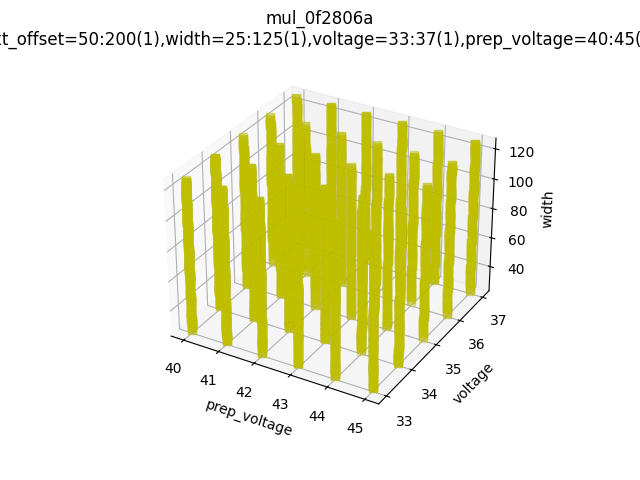

No such comm: 94dd1dfea5744794b0c2f1a7ae17b871


In [21]:
%matplotlib widget

fig3d = plt.figure()
fig3d.suptitle(f'{TABLE}\n{','.join(settings)}')
ax3d = fig3d.add_subplot(projection='3d')
ax3d.set_xlabel('prep_voltage')
ax3d.set_ylabel('voltage')
ax3d.set_zlabel('width')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	if result == GlitchResult.NORMAL:
		continue
	ax3d.plot(prep_voltage, voltage, width, mapper[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)

HALF_SUCCESS at 42->34


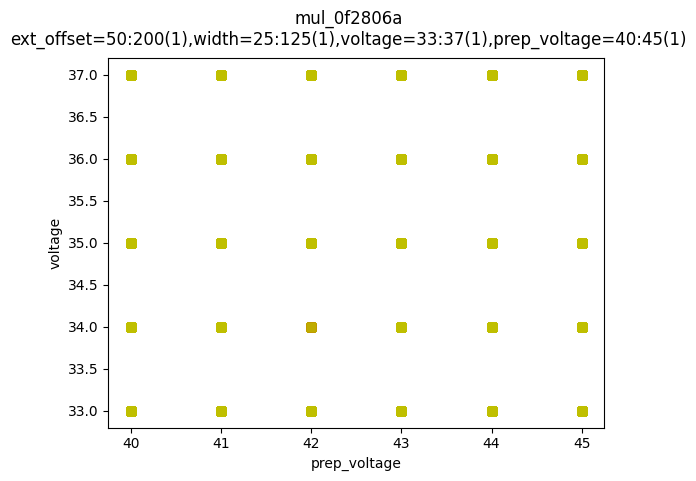

In [28]:
%matplotlib inline
fig_vp_vf, ax_vp_vf = plt.subplots()
fig_vp_vf.suptitle(f'{TABLE}\n{','.join(settings)}')
ax_vp_vf.set_xlabel('prep_voltage')
ax_vp_vf.set_ylabel('voltage')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.NORMAL:
		continue
	marker = mapper[result]
	alpha = 0.05 if marker != 'sr' else 1
	ax_vp_vf.plot(prep_voltage, voltage, marker, alpha=alpha)

	if result in [GlitchResult.HALF_SUCCESS, GlitchResult.SUCCESS]:
		print(f'{result_name} at {prep_voltage}->{voltage}')

## Plotting only half success and success

In [ ]:
%matplotlib inline

col_num = ceil(sqrt(len(voltages)))
row_num = ceil(len(voltages) / col_num)

fig = plt.figure(layout="tight")
axs = {}
for i, voltage in enumerate(voltages):
	axs[voltage] = fig.add_subplot(row_num, col_num, i+1)
	axs[voltage].set_title(f'VID {voltage}')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.HALF_SUCCESS:
		axs[voltage].plot(width, ext_offset, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		axs[voltage].plot(width, ext_offset, 'sr', alpha=0.5)

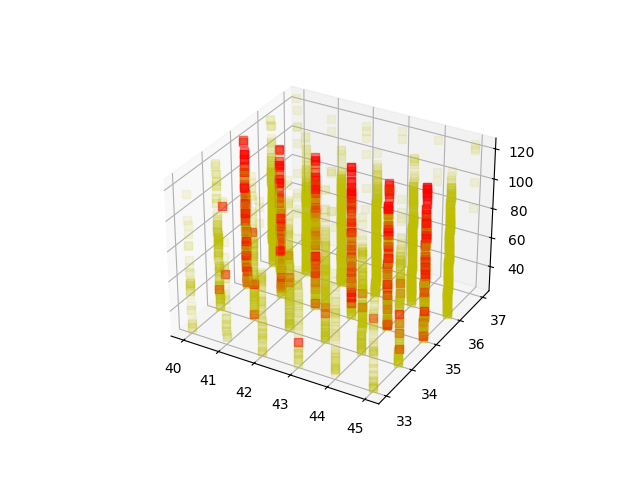

In [20]:
%matplotlib widget

fig3d = plt.figure()
ax3d = fig3d.add_subplot(projection='3d')

for i, row in enumerate(rows):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	if result == GlitchResult.HALF_SUCCESS:
		ax3d.plot(prep_voltage, voltage, width, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		ax3d.plot(prep_voltage, voltage, width, 'sr', alpha=0.5)

In [ ]:
%matplotlib inline
fig_vp_vf, ax_vp_vf = plt.subplots()

for i, row in enumerate(rows):
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.HALF_SUCCESS:
		ax_vp_vf.plot(prep_voltage, voltage, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		ax_vp_vf.plot(prep_voltage, voltage, 'sr', alpha=0.5)

Fix Vf to 35 (other values are less interesting) and plot a 2D grapgh with Vp and width

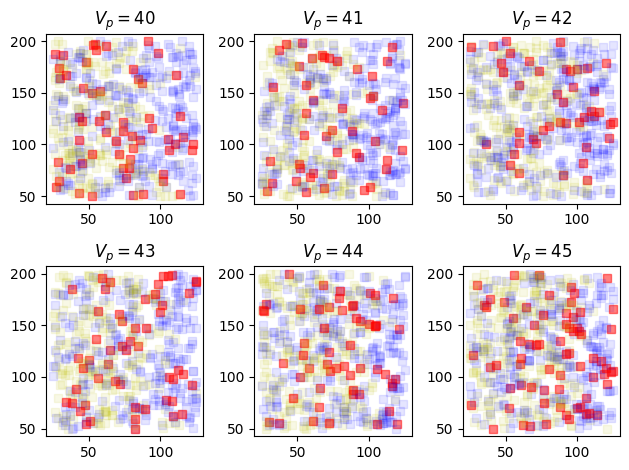

In [24]:
%matplotlib inline

c.execute(f'SELECT * FROM {TABLE} WHERE voltage = 35')
rows_vp_35 = c.fetchall()

c.execute(f'SELECT DISTINCT prep_voltage FROM {TABLE}')
prep_voltages = [v for (v,) in c.fetchall()]
prep_voltages.sort()

col_num = ceil(sqrt(len(prep_voltages)))
row_num = ceil(len(prep_voltages) / col_num)

fig_vp = plt.figure(layout="tight")
axs_vp = {}
for i, prep_voltage in enumerate(prep_voltages):
	axs_vp[prep_voltage] = fig_vp.add_subplot(row_num, col_num, i+1)
	axs_vp[prep_voltage].set_title(f'$V_p = {prep_voltage}$')

for i, row in enumerate(rows_vp_35):
	[ext_offset, width, voltage, prep_voltage, result_name, data, successes, result_a, result_b] = row
	result = GlitchResult[result_name]

	# if result in [GlitchResult.NORMAL, GlitchResult.SUCCESS, GlitchResult.HALF_SUCCESS]:
	if result == GlitchResult.HALF_SUCCESS:
		axs_vp[prep_voltage].plot(width, ext_offset, 'sy', alpha=0.1)
	elif result == GlitchResult.SUCCESS:
		axs_vp[prep_voltage].plot(width, ext_offset, 'sr', alpha=0.5)
	elif result in [GlitchResult.BROKEN, GlitchResult.RESET]:
		axs_vp[prep_voltage].plot(width, ext_offset, 'sb', alpha=0.1)